In [1]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

In [2]:
DATA_DIR = "/mnt/ernie_main/Ghassan/ephys/data/periconnectivity"
peri_fs = glob.glob(os.path.join(DATA_DIR, "*pat*.csv"))



In [3]:
print(f"loading file: {peri_fs[-5]}")
tst = pd.read_csv(peri_fs[-1])


loading file: /mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Spat49.csv


In [4]:
len(peri_fs)

75

In [5]:
grp_peri_dfs = []
check_list = []
for f in peri_fs:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    peri_df = pd.read_csv(f)
    try:
        peri_event_df = center_onset(peri_df)
        grp_peri_dfs.append(peri_event_df)
    except IndexError as e:
        print(f) 
        check_list.append(f)
grp_peri_dfs = pd.concat(grp_peri_dfs)

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:577: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['win_sz_centered'] = center_windows(event_df.window_designations, event_df.period.values,center_designations=center_designations)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:583: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['sz_end'] = get_sz_end(event_df)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/c

In [6]:
print(f"Successfully loaded {len(set(grp_peri_dfs.patID))} patients ecords")
check_list

Successfully loaded 75 patients ecords


[]

In [7]:
set(grp_peri_dfs[grp_peri_dfs.patID=='Epat02'].eventID)

{3, 4, 5, 6, 7, 8, 9, 10, 11}

In [24]:
tmp_df

,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,eventID,patID,sz_type,win_sz_centered,sz_end,win_sz_st_end,win_label
46764,0,soz,2.109146,2.175587,0.066441,delta,0.0_0.0_0.0,3,Epat02,FBTC,-595.0,108.0,-595.0,interictal
62340,0,soz,-0.622847,-0.426408,0.196439,delta,0.0_0.0_0.0,4,Epat02,FBTC,-595.0,90.0,-595.0,interictal
77700,0,soz,-1.056534,-1.835081,-0.778547,delta,0.0_0.0_0.0,5,Epat02,FBTC,-595.0,123.0,-595.0,interictal
93456,0,soz,3.049165,3.524686,0.475521,delta,0.0_0.0_0.0,6,Epat02,FBTC,-595.0,115.0,-595.0,interictal
109116,0,soz,2.546278,2.433601,-0.112677,delta,0.0_0.0_0.0,7,Epat02,FBTC,-595.0,122.0,-595.0,interictal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56580,0,soz,-1.627379,-0.919991,0.707388,delta,0.0_0.0_0.0,12,Spat52,"Focal, unknown awareness",NaN,NaN,NaN,NaN
24156,0,soz,-0.471535,0.411692,0.883227,delta,0.0_0.0_0.0,11A,Spat52,FIAS,-595.0,201.0,-595.0,interictal
0,0,soz,-2.101763,-1.380088,0.721675,delta,0.0_0.0_0.0,10,Spat52,"Focal, unknown awareness",-595.0,152.0,-595.0,interictal
0,0,soz,1.160881,1.287320,0.126439,delta,0.0_0.0_0.0,1,Spat53,FBTC,-595.0,118.0,-595.0,interictal


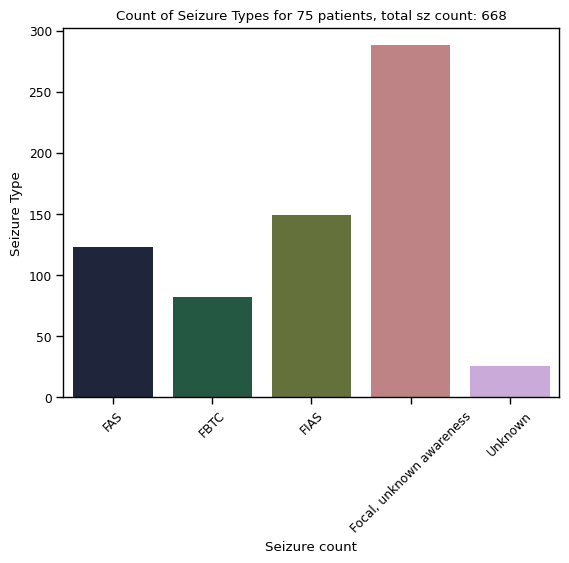

In [10]:
tmp_df = grp_peri_dfs[grp_peri_dfs.period ==0]
tmp_df  =tmp_df[tmp_df.region == 'soz']
tmp_df = tmp_df[tmp_df.freq_band == 'delta']
count_df = tmp_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
total_sz = count_df.eventID.sum()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        ax = sns.barplot(count_df, x='sz_type', y='eventID', hue="sz_type")
        _ = plt.xticks(rotation=45)
        _ = plt.title(f"Count of Seizure Types for 75 patients, total sz count: {total_sz}")
        plt.xlabel("Seizure count")
        plt.ylabel("Seizure Type")
        plt.savefig("../viz/sz_counts.svg", format='svg', dpi=600, transparent=True)



# Visualizing seizure-centered connectivity dynamics

In [12]:
tmp_df = grp_peri_dfs.dropna()
peri_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_st_end']].groupby(['patID','region','freq_band', 'win_sz_st_end']).mean().reset_index()
peri_stats_df.shape[0]


1513800

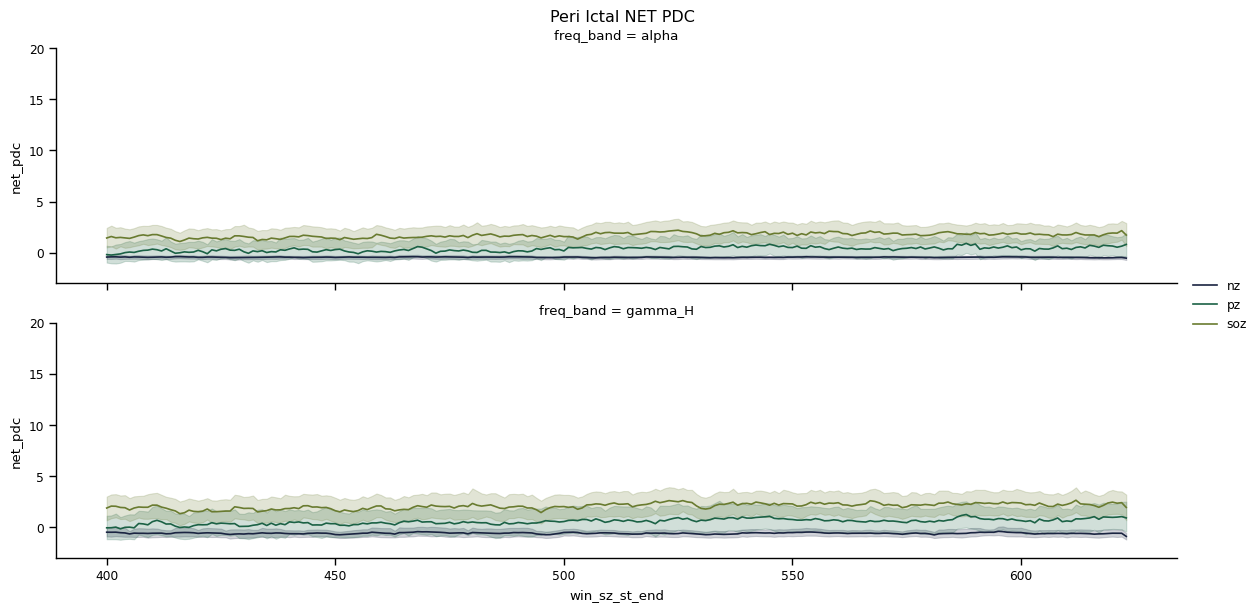

In [35]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        plot_df = peri_stats_df[peri_stats_df.win_sz_st_end >399]
        # plot_df = plot_df[plot_df.win_sz_st_end>-100]
        grid = sns.FacetGrid(plot_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=4) 
        ax = grid.map_dataframe(sns.lineplot, y='net_pdc',x='win_sz_st_end', hue='region')
        ax.set(ylim=(-3, 20))
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal NET PDC",y=1.01)
        #plt.xticks(np.linspace(-600,400,3))
        plt.savefig("../viz/peri_Epat_FULL_peri_NETpdc_zscore_post_ictal.pdf", format='pdf', transparent=True)


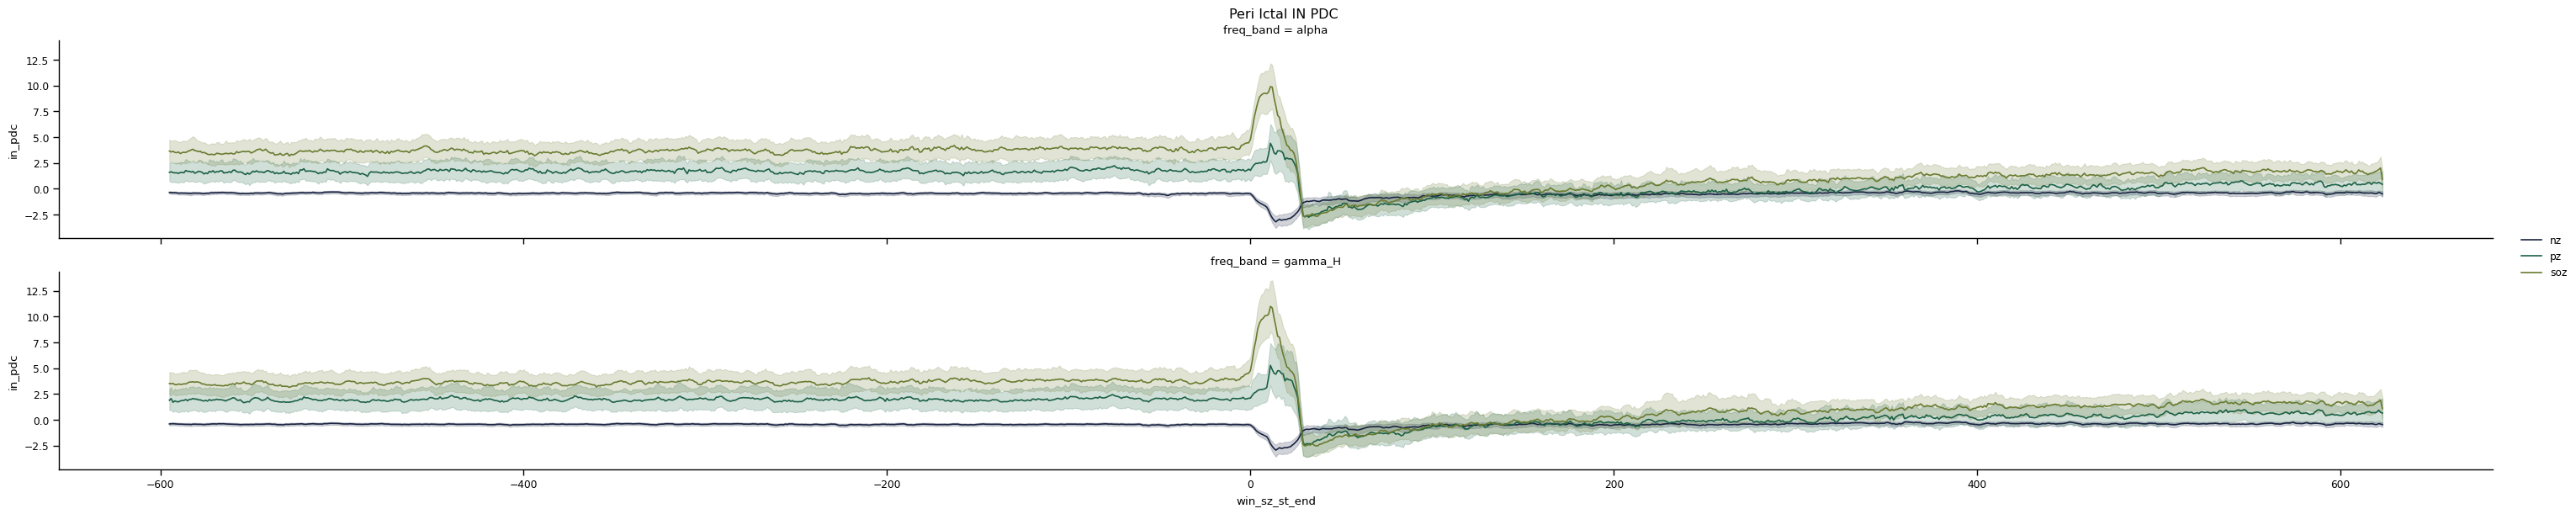

In [11]:
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        grid = sns.FacetGrid(peri_stats_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=4) 
        grid.map_dataframe(sns.lineplot, y='in_pdc',x='win_sz_st_end', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal IN PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_peri_INpdc_zscore_windowed.pdf",transparent=True)


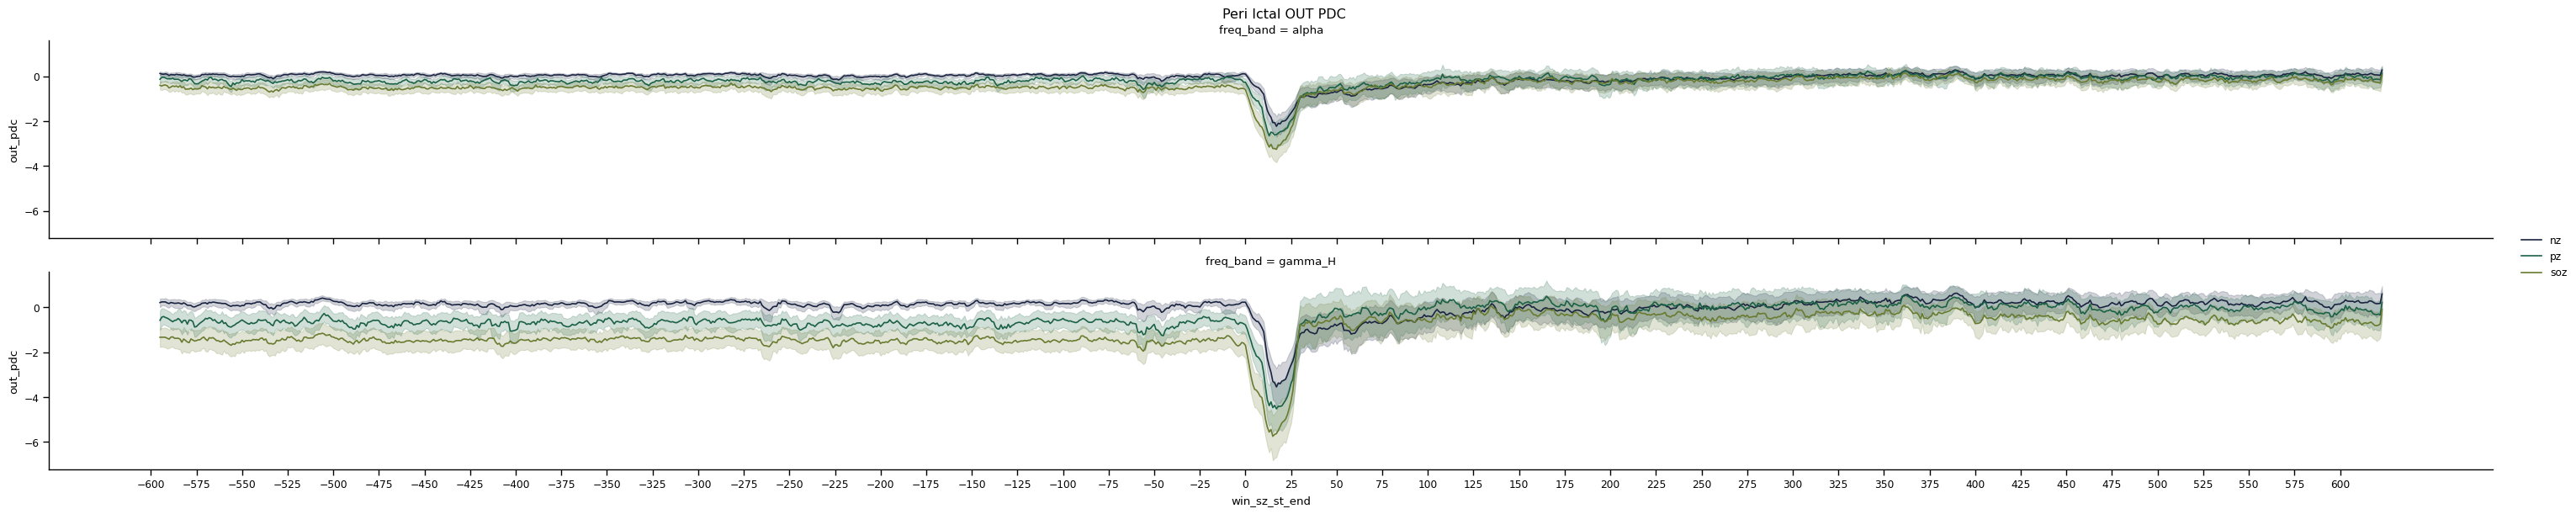

In [38]:
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        grid = sns.FacetGrid(peri_stats_df, row='freq_band',row_order=['alpha','gamma_H'],aspect=10) 
        grid.map_dataframe(sns.lineplot, y='out_pdc',x='win_sz_st_end', hue='region')
        grid.add_legend()
        plt.xticks(np.linspace(-600,600,49))

        grid.figure.suptitle("Peri Ictal OUT PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_peri_OUTpdc_zscore_windowed.pdf",transparent=True)


TODO:
1. Label backwards from first seizure window
1. sample 5 windows in seizure span
1. align seizure end windows
1. aggregate all subjs

In [ ]:
peri_df

In [ ]:
tst = peri_df[peri_df.freq_band =='alpha']
tst = tst[tst.region =='soz']
tst[tst.window_designations == '0.0_1.0_1.0']

In [ ]:
Counter(tst.window_designations)